# Approximate Leave-One-Out Cross-Validation
*This notebook finds hyperparameters that optimize the approximate leave-one-out cross-validation and compares approximate leave-one-out CV to leave-one-out CV.*

## Import Dependencies

In [1]:
import numpy as np
import scipy
import peak_engines
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import expit

## Prepare Dataset

In [2]:
X, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X)

## Compute LOOCV by brute force

In [3]:
def compute_loocv(X, y, C):
    model = LogisticRegression(solver='lbfgs', C=C)
    cv = LeaveOneOut()
    loo_likelihoods = []
    for train_indexes, test_indexes in cv.split(X):
        X_train, X_test = X[train_indexes], X[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)[0]
        loo_likelihoods.append(pred[y_test[0]])
    return sum(np.log(loo_likelihoods))

## Compute approximate LOOCV
At a 
high level, this is how the approximate leave-one-out CV works: For given hyperparameters `C`, we
1. Find the parameters `b` that optimize logistic regression for the given `C`.
2. For each data index `i`, we compute the hessian `H_{-i}` and gradient `g_{-i}` of the 
log-likelihood with the ith data entry removed. (We can reuse the hessian computed from (1) to do this
with a minimal amount of work.)
3. We apply the [Matrix Inversion Lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to
efficiently compute the inverse `H_{-i}^{-1}`.
4. We use `H_{-i}^{-1}` and `g_{-i}` to take a single step of [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) to approximate the logistic regression coefficients with the ith entry removed `b_{-i}`.
5. And finally, we used the `b_{-i}`'s to approximate the out-of-sample predictions and estimate the leave-one-out cross-validation.

In [4]:
def fit_logistic_regression(X, y, C):
    model = LogisticRegression(solver='lbfgs', C=C)
    model.fit(X, y)
    return np.array(list(model.coef_[0]) + list(model.intercept_))

def compute_hessian(p_vector, X, alpha):
    n, k = X.shape
    a_vector = np.sqrt((1 - p_vector)*p_vector)
    R = scipy.linalg.qr(a_vector.reshape((n, 1))*X, mode='r')[0]
    H = np.dot(R.T, R)
    for i in range(k-1):
        H[i, i] += alpha
    return H

def compute_aloocv(X, y, C):
    alpha = 1.0 / C
    w = fit_logistic_regression(X, y, C)
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    n = X.shape[0]
    y = 2*y - 1
    u_vector = np.dot(X, w)
    p_vector = expit(u_vector*y)
    H = compute_hessian(p_vector, X, alpha)
    L = np.linalg.cholesky(H)
    T = scipy.linalg.solve_triangular(L, X.T, lower=True)
    h_vector = np.array([np.dot(ti, ti) for pi, ti in zip(p_vector, T.T)])
    loo_u_vector = u_vector - y * (1 - p_vector)*h_vector / (1 - p_vector*(1 - p_vector)*h_vector)
    loo_likelihoods = expit(y*loo_u_vector)
    return sum(np.log(loo_likelihoods))

## Find the value of C that optimizes ALOOCV
We use the **peak_engines** to find the optimal C. It differentiates ALOOCV with respect to C and iterates an optimizer to find the best C.

In [5]:
C_opt = peak_engines.LogisticRegressionModel().fit(X, y).C_[0]
print(C_opt)

0.6647487922434979


## How accurate is the approximate leave-one-out CV?
We compute the leave-one-out CV by brute force and compare to the approximate leave-one-out CV.

In [6]:
Cs = np.arange(0.1, 2.0, 0.1)
loocvs = [compute_loocv(X, y, C) for C in Cs]
aloocvs = [compute_aloocv(X, y, C) for C in Cs]

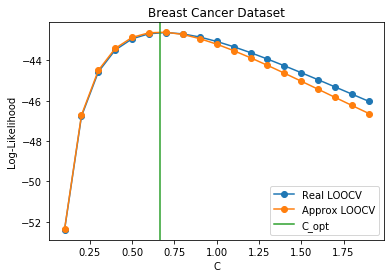

In [7]:
fig, ax = plt.subplots()
ax.plot(Cs, loocvs, label='Real LOOCV', marker='o')
ax.plot(Cs, aloocvs, label='Approx LOOCV', marker='o')
ax.axvline(C_opt, color='tab:green', label='C_opt')
ax.set_xlabel('C')
ax.set_ylabel('Log-Likelihood')
ax.set_title("Breast Cancer Dataset")
ax.legend()

In [8]:
delta = 0.001
print(compute_aloocv(X, y, C_opt-delta))
print(compute_aloocv(X, y, C_opt))
print(compute_aloocv(X, y, C_opt+delta))

-42.59237360703451
-42.5915566398912
-42.59166113176998
